Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import glob
import time
import re
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

Importing Database

In [2]:
df = pd.read_csv('data.csv')
df = df.rename(columns={"Primary Type":"PrimaryType"}) #change the column name to remove whitespace

In [ ]:
df['PrimaryType'].value_counts() #occurence of each crime type

In [ ]:
df = df.dropna() #remove rows including null values
df = df.drop(df.index[(df.PrimaryType == 'DOMESTIC VIOLENCE') | (df.PrimaryType =='NON-CRIMINAL (SUBJECT SPECIFIED)') | (df.PrimaryType =='RITUALISM')]) #since we want to make several models with different size and using kfold, output classes with small number of occurence will raise error
df = df.reset_index(drop = True)
df['PrimaryType'].value_counts().shape #number of crime types

In [ ]:
df.info()

In [ ]:
#different classes of columns with object data type
print(df['Day_Period'].unique())
print(df['weekday'].unique())
print(df['day_of_week'].unique())
print(df['Location Description'].unique())

In [5]:
df_mod = df.copy()

In [6]:
#mapping weekday to binary classes
df_mod['weekday'] = df_mod['weekday'].map({'Weekday' : 0, 'Weekend':1})
df_mod = df_mod.rename(columns={"weekday":"weekend"})

In [ ]:
#encode datas with several classes using labelencoder
label = preprocessing.LabelEncoder()
encoder = pd.DataFrame(label.fit_transform(df_mod[['Location Description']]))
df_mod['Location Description'] = encoder
encoder = pd.DataFrame(label.fit_transform(df_mod[['day_of_week']]))
df_mod['day_of_week'] = encoder
encoder = pd.DataFrame(label.fit_transform(df_mod[['Day_Period']]))
df_mod['Day_Period'] = encoder
encoder = pd.DataFrame(label.fit_transform(df_mod[['PrimaryType']]))
df_mod['PrimaryType'] = encoder

In [ ]:
df_mod.corr(method='pearson', min_periods=1) #find the correlation of features

In [10]:
df_mod_reduced = df_mod.sample(1000000, random_state=1)

In [11]:
X = df_mod_reduced.iloc[:,1:]
y = df_mod_reduced.iloc[:,0]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [ ]:
#make sure we have all types of crime both in y train and y test
y_train.unique().shape, y.unique().shape, df_mod_reduced['PrimaryType'].unique().shape, df['PrimaryType'].unique().shape

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [72]:
kfold = KFold(n_splits = 5, shuffle = True, random_state =1)

In [9]:
classifiers = []
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
NB = GaussianNB()
DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
RF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
XGB = XGBClassifier(n_estimators=10,max_depth = 5,gamma = 0)
classifiers.append(KNN)
classifiers.append(NB)
classifiers.append(DT)
classifiers.append(RF)
classifiers.append(XGB)
classifiers_names = ['KNN', 'NB', 'DT', 'RF', 'XGB']

In [ ]:
results = []
for i in range(len(classifiers)):    
    print(classifiers_names[i], cross_val_score(classifiers[i], X, y, cv=kfold, scoring='accuracy').mean()) #finding best model

In [ ]:
for i in range(X.shape[1]):
    print('feature', i, X.columns[i], XGB.feature_importances_[i]) #identifying most important features

In [74]:
df_mod = df_mod.drop(['day_of_week', 'day'], axis=1) #removing least important features, considering their overlap with other features

In [12]:
#exploring the effect of data size on the accuracy of the model
xgboost = []
xgb_size = []
for i in range(1,5):
    df_resize = df_mod.sample(1000000*i, random_state=1)
    X = df_resize.iloc[:,1:]
    y = df_resize.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    xgboost.append(cross_val_score(XGB, X, y, cv=5, scoring='accuracy').mean())
    xgb_size.append(i*1000000)
xgboost

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(xgb_size, xgboost, c = 'green', label = 'XGBOOST')
plt.xlabel('Dataset Size')
plt.ylabel('Model Accuracy')
plt.legend(loc =(1.05,0))

In [77]:
from sklearn.model_selection import GridSearchCV

In [79]:
#hyperparameter tuning
XGB = XGBClassifier(n_estimators=10,max_depth = 5,gamma = 0)
parameters = [{'n_estimators': [10, 30, 70, 100], 'gamma': [0, 0.01, 0.05, 0.1], 'learning_rate':[0.1, 0.3, 0.7]}]
df_mod_reduced = df_mod.sample(3000000, random_state=1)
X = df_mod_reduced.iloc[:,1:]
y = df_mod_reduced.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [ ]:
grid_search = GridSearchCV(estimator= XGB,
                          param_grid= parameters,
                          scoring='accuracy',
                          cv = 5,
                          n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

In [ ]:
parameters = [{'n_estimators': [10, 30, 70, 100]}]
XGB = XGBClassifier(n_estimators=10,max_depth = 5,gamma = 0.05, learning_rate = 0.3)
grid_search = GridSearchCV(estimator= XGB,
                          param_grid= parameters,
                          scoring='accuracy',
                          cv = 5,)
grid_search.fit(X_train, y_train)

In [ ]:
#modeling with tuned hyperparameters, exploring different data size
XGB = XGBClassifier(n_estimators=100,max_depth = 5,gamma = 0.05, learning_rate = 0.3)
xgboost = []
xgb_size = []
for i in range(5):
    df_resize = df_mod.sample(1000000*(i+1), random_state=1)
    X = df_resize.iloc[:,1:]
    y = df_resize.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)
    xgboost.append(cross_val_score(XGB, X, y, cv=2, scoring='accuracy').mean())
    xgb_size.append((i+1)*1000000)

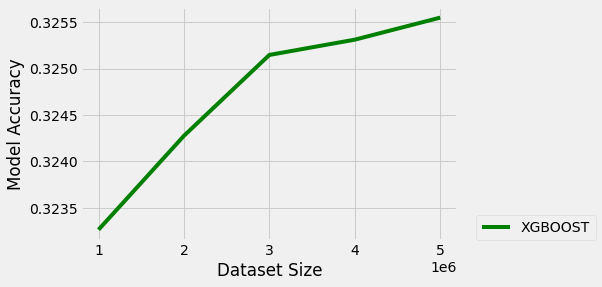

In [13]:
plt.style.use('fivethirtyeight')
plt.plot(xgb_size, xgboost, c = 'green', label = 'XGBOOST')
plt.xlabel('Dataset Size')
plt.ylabel('Model Accuracy')
plt.legend(loc =(1.05,0))